In [1]:
import os

folder_path = "../sample_audio"  # Replace with the actual path to your folder

# Get a list of all files in the folder
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

# Print the list of file names relative to the root directory
for file in file_list:
    print(os.path.relpath(file, folder_path))


sg_parliament_4h.mp3
cna_sg_23min.mp3
sg_parliament_20min.mp3
sg_documentary_45min.mp3


In [2]:
import whisperx
import gc 

with open(r'../keys/hugging_face.txt', 'r') as fp:
    # read all lines using readline()
    lines = fp.readlines()
    for line in lines:
        HF_TOKEN = line

language = 'en'
device = "cuda" 
audio_file = "../sample_audio/sg_parliament_20min.mp3"
batch_size = 16 # reduce if low on GPU mem
compute_type = "float16" # change to "int8" if low on GPU mem (may reduce accuracy)

def whisperx_transcribe(audio_file):
# 1. Transcribe with original whisper (batched)
    model = whisperx.load_model("small", device, compute_type=compute_type, language = language)

    # save model to local path (optional)
    # model_dir = "/path/"
    # model = whisperx.load_model("large-v2", device, compute_type=compute_type, download_root=model_dir)

    audio = whisperx.load_audio(audio_file)
    result = model.transcribe(audio, batch_size=batch_size, language = language)
    print(result["segments"]) # before alignment

    # delete model if low on GPU resources
    # import gc; gc.collect(); torch.cuda.empty_cache(); del model

    # 2. Align whisper output
    model_a, metadata = whisperx.load_align_model(language_code='en', device=device)
    result = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=False)

    print(result["segments"]) # after alignment

    # delete model if low on GPU resources
    # import gc; gc.collect(); torch.cuda.empty_cache(); del model_a

    # 3. Assign speaker labels
    diarize_model = whisperx.DiarizationPipeline(use_auth_token=HF_TOKEN, device=device)

    # add min/max number of speakers if known
    diarize_segments = diarize_model(audio, min_speakers = 5, max_speakers = 11)
    # diarize_model(audio, min_speakers=min_speakers, max_speakers=max_speakers)

    result = whisperx.assign_word_speakers(diarize_segments, result)
    print(diarize_segments)
    print(result["segments"]) # segments are now assigned speaker IDs
    return result

/media/mldadmin/home/s123mdg310_03/miniconda3/envs/whisperx_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
torchvision is not available - cannot save figures


In [4]:
result = whisperx_transcribe(audio_file)
# for segment in result['segments']:
#     for word in segment['words']:
#         print(word)

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.0.0. Bad things might happen unless you revert torch to 1.x.
[{'text': " I have two buckets of clarification. One, with regard to the standards of the PAP that Prime Minister spoke of. And second, with regard to the circumstances involving the departure of former Speaker Tan Chuang Jin and Cheng Li Hui. So there has been much public disquiet about the transmission of information surrounding Minister Yiswan's arrest by the CPIB, and separately on the affair between Speaker Tan Chuang Jin and MP Cheng Li Hui.", 'start': 0.009, 'end': 27.449}, {'text': ' This is particularly with regard to what the Prime Minister knew and what the Prime Minister did about it over a period of almost three years before coming clean on the matter. So in this term of government, the government has either been slow to clear the air o

In [ ]:
import os

# Define the directory to store transcripts
transcripts_dir = "../transcripts"

# Find the next available transcript file number
transcript_num = 1
while True:
    transcript_filename = f"whisperx_transcript{str(transcript_num).zfill(3)}.txt"
    if not os.path.exists(os.path.join(transcripts_dir, transcript_filename)):
        break
    transcript_num += 1

speakerID_speech = {}
sentence_list = []

# Open the transcript file for writing
with open(os.path.join(transcripts_dir, transcript_filename), "w") as transcript_file:
    prev_speaker = None
    for segment in result['segments']:
        for word in segment['words']:
            if 'speaker' in word and word['speaker'] != prev_speaker:
                transcript_file.write(f"\n\n{word['speaker']}  {word['start']}\n")
                transcript_file.write(word['word'] + " ")
                prev_speaker = word['speaker']
            else:
                transcript_file.write(word['word'] + " ")

# Print the filename of the created transcript file
print(f"Transcript saved as: {transcript_filename}")

Transcript saved as: whisperx_transcript003.txt


In [ ]:
file = open('myfile.txt', 'w')
file.close()


In [5]:
speaker_ids = []
start_time = []
speeches = []

prev_speaker = None
for segment in result['segments']:
    for word in segment['words']:
        if 'speaker' in word and word['speaker'] != prev_speaker:
            speaker_ids.append(word['speaker'])
            start_time.append(word['start'])
            speeches.append(word['word'] + " ")
            prev_speaker = word['speaker']
        else:
            # If the word does not indicate a speaker change, append to the previous speaker's speech
            speeches[-1] += word['word'] + " "
            if 'end' in word:
                end_of_speech = word['end']
end_time = start_time[1:] + [end_of_speech]

In [6]:
duration = []

# Iterate over the indices of start_time and end_time
for i in range(len(start_time)):
    # Calculate the duration and append it to the duration list
    duration.append(float(end_time[i]) - float(start_time[i]))

In [24]:
import pandas as pd
data = {
    'speaker_id': speaker_ids,
    'duration': duration,
    'speech': speeches
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
display(df)

,speaker_id,duration,speech
0,SPEAKER_02,492.816,"I have two buckets of clarification. One, with..."
1,SPEAKER_04,22.867,"Before I ask Prime Minister to respond, I have..."
2,SPEAKER_01,338.989,"Mr Speaker, let me deal first with a question ..."
3,SPEAKER_00,133.813,"Mr Speaker, let me address the clarification w..."
4,SPEAKER_04,1.702,"Leader of the opposition, Mr Pritam"
5,SPEAKER_02,198.090,"Singh. Thank you, Speaker. Just the first poin..."


In [23]:


# Print the total time each speaker spoke

In [25]:
df.to_csv(r"../runs/Part1/run1/metadata/output.csv", index=False)

In [27]:
df = pd.read_csv(r"../runs/Part1/run1/metadata/output.csv")
speaker_totals = df.groupby('speaker_id')['duration'].sum().sort_values(ascending=False)

In [28]:
max_speaker = speaker_totals.idxmax()
min_speaker = speaker_totals.idxmin()
max_duration = speaker_totals[max_speaker]
min_duration = speaker_totals[min_speaker]

# Average speaking time per speaker
average_duration = speaker_totals.mean()

print(f"Spoke the most: {max_speaker} ({max_duration:.2f} seconds)")
print(f"Spoke the least: {min_speaker} ({min_duration:.2f} seconds)")
print(f"Average speaking time: {average_duration:.2f} seconds")

Spoke the most: SPEAKER_02 (690.91 seconds)
Spoke the least: SPEAKER_04 (24.57 seconds)
Average speaking time: 297.07 seconds


In [62]:
meta_data = {'max_speaker_id': max_speaker, 'max_speaker_duration':max_duration.round(2), 'min_speaker_id': min_speaker, 'min_speaker':min_duration.round(2), "average_duration":average_duration.round(2), 'total_speaker': len(speaker_totals)}
print(meta_data)

{'max_speaker_id': 'SPEAKER_09', 'max_speaker_duration': 671.9, 'min_speaker_id': 'SPEAKER_04', 'min_speaker': 4.9, 'average_duration': 129.5, 'total_speaker': 11}


In [5]:
# !pip instal wordcloud
# !pip install nltk
# !pip install textblob
import nltk
nltk.download('punkt')  # Download sentence tokenizer
nltk.download('averaged_perceptron_tagger')  # Download POS tagger
from nltk import word_tokenize, pos_tag, FreqDist
from nltk.corpus import stopwords
from textblob import TextBlob  # Sentiment analysis
from collections import Counter  # Counter for trigrams
from wordcloud import WordCloud  # Wordcloud generation
import matplotlib.pyplot as plt

with open("../transcripts/whisperx_transcript002.txt", "r") as f:
    text = f.read()
sentences = nltk.sent_tokenize(text)

filtered_tokens = [[word.lower() for word in word_tokenize(sentence) if word.lower() not in stopwords.words('english') and word.lower().isalnum()] for sentence in sentences]

# Flatten the list of tokens
all_words = [word for sentence_words in filtered_tokens for word in sentence_words]

# Perform part-of-speech tagging
pos_tags = pos_tag(all_words)

# Extract trigrams (collocations)
trigrams = nltk.trigrams(all_words)

# Count frequencies of words
word_freq = FreqDist(all_words)

# Generate word cloud for meaningful words
wordcloud = WordCloud().generate_from_frequencies(word_freq)


[nltk_data] Downloading package punkt to
[nltk_data]     /media/mldadmin/home/s123mdg310_03/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /media/mldadmin/home/s123mdg310_03/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
from nltk.corpus import wordnet

# Define noun tags based on NLTK's tagset
NOUN_TAGS = ['NN', 'NNS', 'NNP', 'NNPS']  # Common noun tags (singular, plural, proper singular, proper plural)
words = nltk.tokenize.word_tokenize(text)
words = [word.lower() for word in words if word not in stopwords.words('english')]
# Filter most frequent nouns
fdist = nltk.FreqDist(words)
most_freq_nouns = [w for w, c in fdist.most_common(40)
                   if nltk.pos_tag([w])[0][1] in NOUN_TAGS]

print(most_freq_nouns) # not very useful

['i', 'chuan', 'feel', 'time', 'speaker_03', 'speaker_00', 'want', 'bit', 'husband', 'friend', 'family', 'thank', 'jeremy']


Visual Analysis
Number of words excluding punctuation & stopwords: 1980


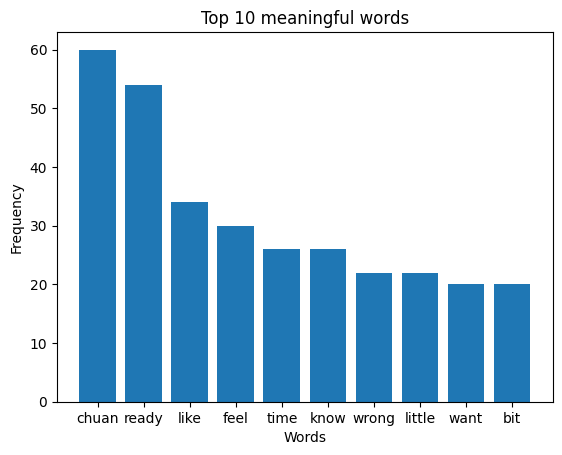

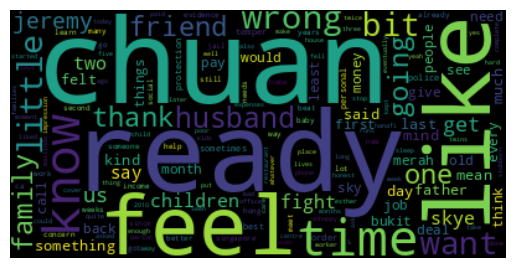

Graph Analysis
Num questions asked: 99
Most commonly asked questions: Are you ready? ( 23 asked)


In [19]:
# Visual Analysis
print("Visual Analysis")
# Number of words excluding punctuation & stopwords
filtered_words_no_punct = [word for word in all_words if word.isalnum()]
num_words_no_punct = len(filtered_words_no_punct)
print("Number of words excluding punctuation & stopwords:", num_words_no_punct)
# Visual frequency chart of top 10 meaningful words (use matplotlib)
top_words = word_freq.most_common(10)
plt.bar(range(len(top_words)), [freq for word, freq in top_words], align='center')
plt.xticks(range(len(top_words)), [word for word, freq in top_words])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 meaningful words')
plt.show()
# Visual word cloud of most meaningful used words
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Graph Analysis
print("Graph Analysis")
num_questions_asked = sum(1 for sentence in sentences if '?' in sentence)
print("Num questions asked:", num_questions_asked)
speaker_questions = Counter([line.split(":")[0].strip() for line in sentences if '?' in line])
speaker_answers = Counter([line.split(":")[0].strip() for line in sentences if '?' not in line and line.strip() != ''])
most_questions_asked = max(speaker_questions, key=speaker_questions.get)
most_answers_given = max(speaker_answers, key=speaker_answers.get)
print("Most commonly asked questions:", most_questions_asked, "(", speaker_questions[most_questions_asked], "asked)")